# PART I: Encoding images into StyleGAN's latent space

![alt text](https://miro.medium.com/max/1280/0*eeFaGLx96mlbQcrK.gif)

## I. Imports & Clean

1. Upgrade tqdm & Restart the Python kernel to load the updated version:

In [0]:
!pip install --upgrade tqdm
import os 
os.kill(os.getpid(), 9)

     |████████████████████████████████| 71kB 3.4MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


2. Mount Drive:

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


3. Clone Github repo: https://github.com/pbaylies/stylegan-encoder

In [1]:
!rm -rf sample_data
!git clone https://github.com/alehuger/stylegan

Cloning into 'stylegan'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 62 (delta 4), reused 62 (delta 4), pack-reused 0
Unpacking objects: 100% (62/62), done.


4. housekeeping: setting up folder structure for our images

In [2]:
cd stylegan

/content/stylegan


In [0]:
# rm -rf aligned_images raw_images
!mkdir aligned_images raw_images

## II. Get Images & Preprocessing:

##### Some tips for the images:


*   Use HD images (preferably > 1000x1000 pixels)
*   Make sure your face is not too small
*   Neutral expressions & front facing faces will give better results
*   Clear, uniform lighting conditions are also recommened



### Get Image from GDrive folder

In [0]:
DIR_PATH = "../gdrive/My\ Drive/stylegan/TOP8"
COPY_PATH = DIR_PATH + '/.'

In [0]:
!cp -r $COPY_PATH raw_images

### Data Check:

Found 4 images in raw_images
['alex.png', 'auguste.png', 'tom.JPG', 'tom.png']


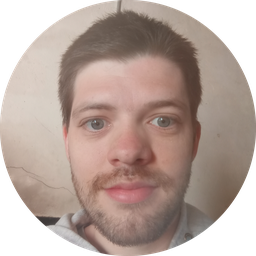

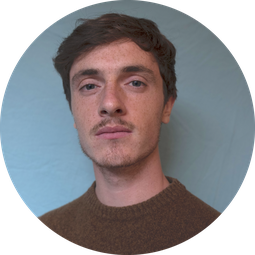

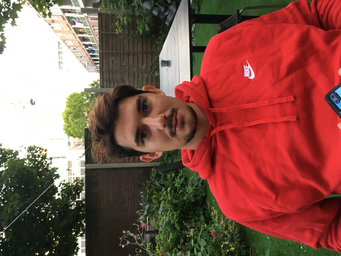

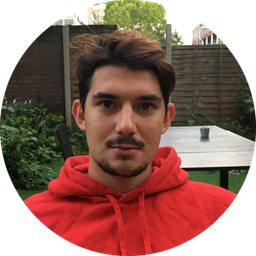

In [56]:
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)


In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import tqdm
print(tf.__version__)
print(tqdm.__version__)

TensorFlow 1.x selected.
1.15.2
4.46.0


### Auto-Align faces:


##### This script wil:


1.   Look for faces in the images
2.   Crop out the faces from the images
3.   Align the faces (center the nose and make the eyes horizontal)
4.   Rescale the resulting images and save them in "aligned_images" folder




In [57]:
!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
Aligning alex.png ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/alex_01.png
Aligning tom.JPG ...
Getting landmarks...
Aligning auguste.png ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/auguste_01.png
Aligning tom.png ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/tom_01.png


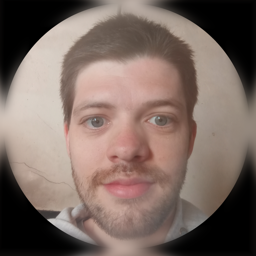

'img 0: alex_01.png'

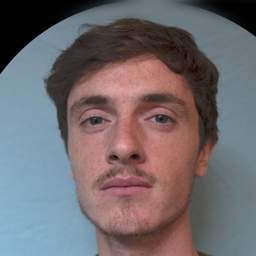

'img 1: auguste_01.png'

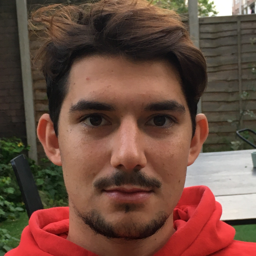

'img 2: tom_01.png'

In [58]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

#####  Manual clean 'aligned_images' directory

1. Remove all 'bad' images that are not faces / don't look sharp / clear 
2. Make sure you don't have too many faces in this folder (8 at most preferably)




## III. Encoding faces into StyleGAN latent space:

#### A. Downloading Pretrained Network Weights

A. Pretrained ResNet Encoder

Image as input estimates the corresponding latent code

In [0]:
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:02, 115MB/s]


B. Pretrained VGG & StyleGAN Encoder

In [0]:
!cp '../gdrive/My Drive/stylegan/weights/karras2019stylegan-ffhq-1024x1024.pkl' /weights
!cp ../gdrive/My\ Drive/stylegan/weights/vgg16_zhang_perceptual.pkl /weights

### B. The actual encoding process:


Notes:

https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py

This script will also download:

*   The pretrained StyleGAN network from NVIDIA trained on faces
*   A pretrained VGG-16 network, trained on ImageNet

After guessing the initial latent codes using the pretrained ResNet, it will run gradient descent to optimize the latent faces!
Note that by default, we're optimizing w vectors, not z-vectors!

Important: to avoid issues, set the batch_size argument lower than or equal to the number of aligned_images (see previous cell)
> Keep batch_size<8 or the GPU might run out of memory

In [59]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))
print("Recommended batch_size for the encode_images process: %d" %min(len(os.listdir('aligned_images/')), 8))

aligned_images contains 3 images ready for encoding!
Recommended batch_size for the encode_images process: 3


#### Image Encoding Script

Use Slow version for optimization
Override encode_images script with:

In [0]:
#!python encode_images.py --optimizer=lbfgs --face_mask=True --iterations=6 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
#print("\n************ Latent code optimization finished! ***************")

In [76]:
!python encode_images.py --optimizer=adam --lr=0.02 --decay_rate=0.92 --decay_steps=6 --use_l1_penalty=0.3 --face_mask=True --iterations=800 --early_stopping=True --early_stopping_threshold=0.05 --average_best_loss=0.5 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
print("\n************ Latent code optimization finished! ***************")




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
If using Keras pass *_constraint arguments to layers.

  0% 0/3 [00:00<?, ?it/s]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.


Loading mask masks/auguste_01.png

  0% 0/800 [00:00<?, ?it/s]WARNING:tensorflow:From /content/stylegan/encoder/perceptual_model.py:292: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

auguste_01: loss 160.1209; lr 0.0200:   0% 0/800 [00:03<?, ?it/s]
auguste_01: loss 160.1209; lr 0.0200:   0% 1/800 [00:03<49:32,  3.72s/it]
auguste_01: loss 119.2651; lr 0.0200:   0% 1/

## IV. Generation from found latent space encoding

In [14]:
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'weights/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")







Loading StyleGAN model from weights/karras2019stylegan-ffhq-1024x1024.pkl...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded & ready for sampling!


In [0]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

### Results 
### If the results don't look great: Play with the encoding arguments!!!
> 1. Run the optimization for more iterations (eg 500)
> 2. Decrease the L1 penalty (to eg 0.15)
> 3. Try a lower initial learning rate (eg 0.02) or play with the decay_rate
> 4. Find out about the other encoding options here: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py
> 5. You can find a bunch of good presets on the repo documentation: https://github.com/pbaylies/stylegan-encoder

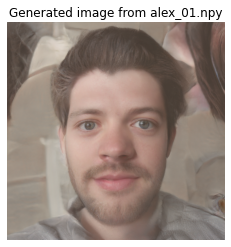

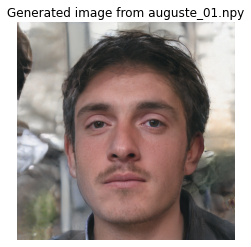

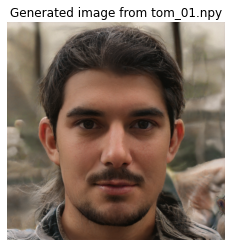

In [79]:
for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

### Compare our encoded samples with original ones:

**Note: when you optimized with the setting --face_mask=True, the hair will be copied from the source images. If you don't want this, optimize without that setting!**

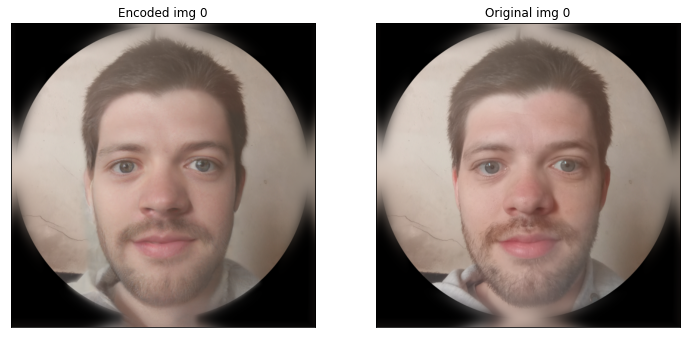

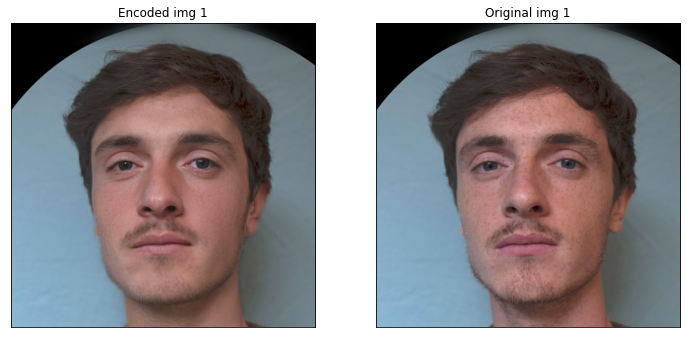

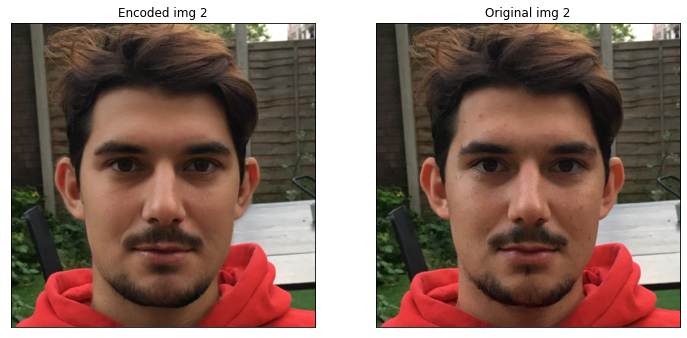

In [81]:
import matplotlib.pyplot as plt

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images/', 'aligned_images/', res = 512)

### Note: 
If you want to watch the whole thing unfold for yourself, you can **download the optimization videos** from the "videos" folder

## V. Formatting Results and Cleaning

### Manipulating latent vectors (Notebook II) is tricky and will only work well if the face encoding looks 'good'

In [0]:
good_images = list(range(3))  #Change these numbers to pick out latents that worked well (see the image plots)

### Save these latent vectors to disk:

In [83]:
import numpy as np
latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

3 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!


### Exporting Output Vector

In [0]:
!cp -r latent_representations $DIR_PATH

# PART II. Latent Code Analysis

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import tqdm
import os
import numpy as np

The npz file contains the warped latent representation by an array of shape(18, 512). 
The age structure could be only found in the latent code only (?) z vector

## A. Retrieve Data

In [6]:
cd stylegan

/content/stylegan


In [0]:
latent_path = '../gdrive/My Drive/stylegan/TOP8/latent_representations'
np_files = os.listdir(latent_path)
latent_code = np.array([np.load(latent_path + '/' + filename) for filename in np_files])

## B. 2D Vizualisation of latent code. 

DUMB: the vectro rpz the warped latent space. No sense in comparing each dimension

### PCA

In [0]:
from sklearn.decomposition import PCA
X_pca = np.array(latent_code).reshape(7*18, 512)
pca = PCA(n_components=2)
pca.fit(X_pca)
X_transformed = pca.transform(X_pca).T

In [0]:
x_axis = X_transformed[0]
y_axis = X_transformed[1]

### Latent Code by image

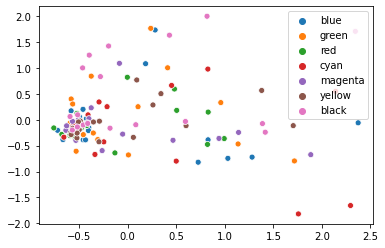

In [0]:
import seaborn as sns
colors= ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'] 
color_array = [colors[int(i/18)] for i in range(126)]
ax = sns.scatterplot(x_axis, y_axis, hue=color_array)

### Mean Latent Code by image

In [0]:
mean_latent_code = np.array([a.mean(axis=0) for a in latent_code ])

In [0]:
X_mean_transformed = pca.transform(mean_latent_code).T

In [0]:
x = X_mean_transformed[0]
y = X_mean_transformed[1]

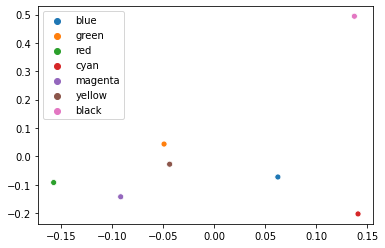

In [0]:
colors= ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'] 
ax = sns.scatterplot(x, y, hue=colors)

## C. Interpolation between latent code

In [0]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

In [0]:
def interpolated_code(code1, code2, nb_interpolation, end=1):
  l= np.linspace(0, end, num=nb_interpolation)
  return np.array( [code1 + t* (code2-code1) for t in l])

In [0]:
def top8(w, nb_interpolations):
  transition_1 = interpolated_code(w[0], w[1], nb_interpolations)
  transition_2 = interpolated_code(w[1], w[2], nb_interpolations)
  transition_3 = interpolated_code(w[2], w[0], nb_interpolations)
  imgs_1 = generate_images(averaged_generator_network, transition_1, z = False)
  imgs_2 = generate_images(averaged_generator_network, transition_2, z = False)
  imgs_3 = generate_images(averaged_generator_network, transition_3, z = False)
  return np.concatenate((imgs_1,imgs_2, imgs_3))

In [0]:
video_data = top8(latent_code, 400)

In [0]:
from moviepy.editor import *
import cv2

video_fps = 70
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('auguste-tom-alex.mp4', fourcc, video_fps, (1024, 1024))

for img in video_data:
  open_cv_image = img[:, :, ::-1]
  video.write(open_cv_image)

cv2.destroyAllWindows()
video.release()

## DUMP

- 6yo = 5
- 7yo = 1
- 8yo = 4
- 9yo = 6


In [0]:
video_data = generate_video_young2mean(1200)

In [0]:
def generate_video_young2mean(nb_interpolations):
  transition_1 = interpolated_code(w[5], mean_latent_code, nb_interpolations, end=2)

  imgs_1 = generate_images(averaged_generator_network, transition_1, z = False)
  return imgs_1


In [0]:
def generate_video_young2middle(nb_interpolations):
  transition_1 = interpolated_code(w[5], w[1], nb_interpolations)
  transition_2 = interpolated_code(w[1], w[4], nb_interpolations)
  #transition_3 = interpolated_code(w[4], w[6], nb_interpolations)
  imgs_1 = generate_images(averaged_generator_network, transition_1, z = False)
  imgs_2 = generate_images(averaged_generator_network, transition_2, z = False)
  #imgs_3 = generate_images(averaged_generator_network, transition_3, z = False)
  return np.concatenate((imgs_1,imgs_2))
